# Segmentation of Indian Traffic

In [43]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os,glob
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import zipfile

In [ ]:
# !pip install tensorflow==2.2
#!pip install keras==2.3.1
# !pip install -U segmentation-models

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile 
# with zipfile.ZipFile('/content/drive/MyDrive/data.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/datafile')

In [3]:
!unzip '/content/drive/MyDrive/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28480_leftImg8bit.jpg  
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/imag

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [4]:
def return_file_names_df(root_dir):
    listOfFile = os.listdir(root_dir)
    list_of_img = list()
    list_of_json = list()
    for i in range(len(listOfFile)) :         
      if(listOfFile[i]=="images"):
            subdirpath = os.path.join(root_dir, "images")
           
            subsubdirs = sorted(os.listdir(subdirpath))           
           
            for subsubdir in subsubdirs:
                
                dirpath = os.path.join(subdirpath, subsubdir)
               
                for filename in sorted((glob.glob(os.path.join(dirpath,'*.jpg')))):
                    list_of_img.append(filename.replace("/content/",""))                 
      
           
      if(listOfFile[i]=="mask"):
            subdirpath_ = os.path.join(root_dir, "mask")
           
            subsubdirs_ = sorted(os.listdir(subdirpath_))            
            
            for subsubdirs_ in subsubdirs_:
                 dirpath_ = os.path.join(subdirpath_, subsubdirs_)
                 for filename_ in sorted(glob.glob(os.path.join(dirpath_,'*.json'))):                   
                    list_of_json.append(filename_.replace("/content/",""))
     
    list_of_tuples = list(zip(list_of_img, list_of_json))     
    # Converting lists of tuples into
    # pandas Dataframe.
    data_df = pd.DataFrame(list_of_tuples,columns = ['images', 'json'])              
    return data_df

In [44]:
root_dir='/content/data'
data_df=return_file_names_df(root_dir)
data_df

,images,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json
...,...,...
4003,data/images/429/frame13262_leftImg8bit.jpg,data/mask/429/frame13262_gtFine_polygons.json
4004,data/images/429/frame13699_leftImg8bit.jpg,data/mask/429/frame13699_gtFine_polygons.json
4005,data/images/429/frame15812_leftImg8bit.jpg,data/mask/429/frame15812_gtFine_polygons.json
4006,data/images/429/frame18062_leftImg8bit.jpg,data/mask/429/frame18062_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:
def grader_1(data_df):
    for i in data_df.values:            
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [45]:
def return_unique_labels(data_df):
    listres=[]
    for j in data_df.json:
      f = open(j)
      # returns JSON object as
      # a dictionary
      data = json.load(f)
      # Iterating through the json
      # list
      for i in data["objects"]:
          listres.append(i.get("label"))
          
        
      # Closing file
      f.close()
      unique_labels=set(listres)
    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

In [ ]:
print(len(unique_labels))

40


<img src='https://i.imgur.com/L4QH6Tp.png'>

In [46]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [47]:
def get_poly(file):
    label=[]
    vertexlist = []

    f = open(file)
    data = json.load(f)
    h=data.get("imgHeight")
    w=data.get("imgWidth")

    for i in data['objects']:
        label.append(i['label'])
        vertexlist.append(i['polygon'])

    vertexlist = [[tuple(l) for l in vertex] for vertex in vertexlist]

    f.close()

    return w, h, label, vertexlist

In [8]:
w, h, label, vertexlist=get_poly("data/mask/201/frame0029_gtFine_polygons.json")

In [73]:
print(len(label),len(vertexlist))

227 227


In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

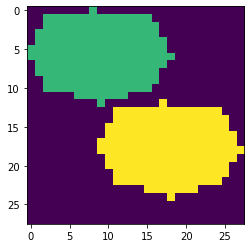

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [48]:
# import shutil

# shutil.rmtree('/content/data/output') #delete the folder 

In [49]:
#Create the sub directory 
source_folder="/content/data"
output_folder = os.path.join(source_folder, "output")
try:
 if not os.path.exists(output_folder):
  os.mkdir(output_folder)              
except OSError as err:
 print("err",err)
subdirpath = os.path.join(source_folder, "mask")
subsubdirs = sorted(os.listdir(subdirpath)) 
for k in subsubdirs:
      Sub_folder = (os.path.join(output_folder,k))
      try:
        if not os.path.exists(Sub_folder):
            os.mkdir(Sub_folder)              
      except OSError as err:
        print("err",err)        

In [50]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
  mask_path=[]
  for file_ in tqdm(data_df["json"]):
    w, h, label, vertexlist=get_poly(file_)
    img = Image.new("RGB", (w, h))
    img1 = ImageDraw.Draw(img)
    for lbl, ver in zip(label, vertexlist):
         try:  
           img1.polygon(ver, fill = label_clr[lbl])
         except:
           pass
    img=np.array(img)
    im = Image.fromarray(img[:,:,0])
    fol=file_.replace("mask","output")
    exet_=fol.replace("json","png")
    im.save(exet_)
    mask_path.append(exet_)
  data_df['mask']= mask_path    
  return data_df

In [51]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:56<00:00, 13.54it/s]


,images,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [14]:
#daving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

In [15]:
data_df=pd.read_csv("/content/preprocessed_data.csv")
data_df_=data_df.drop(['json'], axis = 1)
data_df_

,images,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/output/201/frame1469_gtFine_polygons.png
...,...,...
4003,data/images/429/frame13262_leftImg8bit.jpg,data/output/429/frame13262_gtFine_polygons.png
4004,data/images/429/frame13699_leftImg8bit.jpg,data/output/429/frame13699_gtFine_polygons.png
4005,data/images/429/frame15812_leftImg8bit.jpg,data/output/429/frame15812_gtFine_polygons.png
4006,data/images/429/frame18062_leftImg8bit.jpg,data/output/429/frame18062_gtFine_polygons.png


# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

In [16]:
!pip install tensorflow==2.2
!pip install keras==2.3.1
!pip install -U segmentation-models

     |████████████████████████████████| 516.2 MB 4.5 kB/s 
     |████████████████████████████████| 3.0 MB 30.9 MB/s 
     |████████████████████████████████| 2.9 MB 32.4 MB/s 
     |████████████████████████████████| 454 kB 43.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalli

In [ ]:
# !pip install imgaug

In [52]:
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [18]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape#CuDNNLSTM
from tensorflow.keras.models import Model,load_model
import random as rn
from tensorflow.keras.layers import Flatten

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_df_, test_size=0.15, random_state=42)

In [54]:
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [55]:
model= Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(512,512,3))

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [56]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))

In [68]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
# def normalize_image(mask):
#     mask = mask/255
#     return mask
# Preparing data for training
class Dataset_train:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['road', 'parking', 'sidewalk', 'rail track', 'person', 'rider', 'motorcycle', 
               'car', 'bus', 'wall', 'fence', 'billboard', 'pole', 'building', 'vegetation',
               'sky', 'unlabeled', 'ego vehicle', 'ground', 'rectification border', 'train']
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self,file_names,classes=None):

        self.w=512
        self.h = 512
        self.ids = file_names
        
        
        # the paths of images
      #  self.ids = os.listdir(images_dir)
        self.images_fps = [image_id for image_id in self.ids["images"]]
        self.masks_fps = [image_id for image_id in self.ids["mask"]]
        # the paths of segmentation images
       # self.masks_fps    = file_names["mask"].values
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (self.w,self.h), interpolation=cv2.INTER_NEAREST)

        image_mask = mask

        
        image_masks = [(image_mask/10 == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        else:
            image = aug5.augment_image(image)
            image_mask = image_mask
            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    


In [69]:
class Dataset_test:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['road', 'parking', 'sidewalk', 'rail track', 'person', 'rider', 'motorcycle', 
               'car', 'bus', 'wall', 'fence', 'billboard', 'pole', 'building', 'vegetation',
               'sky', 'unlabeled', 'ego vehicle', 'ground', 'rectification border', 'train']
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self,file_names,classes=None):

        self.w=512
        self.h = 512
        self.ids = file_names
        
        
        # the paths of images
      #  self.ids = os.listdir(images_dir)
        self.images_fps = [image_id for image_id in self.ids["images"]]
        self.masks_fps = [image_id for image_id in self.ids["mask"]]
        # the paths of segmentation images
       # self.masks_fps    = file_names["mask"].values
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (self.w,self.h), interpolation=cv2.INTER_NEAREST)

        image_mask = mask

        
        image_masks = [(image_mask/10 == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)

In [36]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [70]:
# Dataset for train images
CLASSES = ['road', 'parking', 'sidewalk', 'rail track', 'person', 'rider', 'motorcycle', 
               'car', 'bus', 'wall', 'fence', 'billboard', 'pole', 'building', 'vegetation',
               'sky', 'unlabeled', 'ego vehicle', 'ground', 'rectification border', 'train']
train_dataset = Dataset_train(X_train, classes=CLASSES)
test_dataset  = Dataset_test(X_test, classes=CLASSES)

BATCH_SIZE=4
train_dataloader = Dataloder(train_dataset, batch_size=4, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=4, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 21)


(4, 512, 512, 3)


In [60]:
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(4, 512, 512, 3)
(4, 512, 512, 21)


### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [61]:

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Sengment_Weight/best_model.h5', monitor='val_iou_score', mode='max',
                                       save_best_only=True, verbose=1)
    # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2),
]

In [71]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam()

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=[iou_score])

In [72]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=10,\
                              validation_data=test_dataloader,callbacks=callbacks )

Epoch 1/10
851/851 [==============================] - ETA: 0s - loss: 0.6938 - iou_score: 0.2795
Epoch 00001: val_iou_score improved from -inf to 0.35978, saving model to /content/drive/MyDrive/Sengment_Weight/best_model.h5
851/851 [==============================] - 752s 883ms/step - loss: 0.6938 - iou_score: 0.2795 - val_loss: 0.6085 - val_iou_score: 0.3598
Epoch 2/10
851/851 [==============================] - ETA: 0s - loss: 0.5894 - iou_score: 0.3722
Epoch 00002: val_iou_score did not improve from 0.35978
851/851 [==============================] - 735s 863ms/step - loss: 0.5894 - iou_score: 0.3722 - val_loss: 0.6111 - val_iou_score: 0.3570
Epoch 3/10
851/851 [==============================] - ETA: 0s - loss: 0.5632 - iou_score: 0.3933
Epoch 00003: val_iou_score improved from 0.35978 to 0.40378, saving model to /content/drive/MyDrive/Sengment_Weight/best_model.h5
851/851 [==============================] - 748s 879ms/step - loss: 0.5632 - iou_score: 0.3933 - val_loss: 0.5529 - val_iou

In [74]:
model = load_model('/content/drive/MyDrive/Sengment_Weight/best_model.h5',compile=False)
model.compile(optim, focal_loss, metrics=[iou_score])
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=2,
                    validation_data=test_dataloader,callbacks=callbacks)

Epoch 1/2
851/851 [==============================] - ETA: 0s - loss: 0.4620 - iou_score: 0.4957
Epoch 00001: val_iou_score improved from 0.49096 to 0.52860, saving model to /content/drive/MyDrive/Sengment_Weight/best_model.h5
851/851 [==============================] - 771s 906ms/step - loss: 0.4620 - iou_score: 0.4957 - val_loss: 0.4196 - val_iou_score: 0.5286
Epoch 2/2
851/851 [==============================] - ETA: 0s - loss: 0.4009 - iou_score: 0.5471
Epoch 00002: val_iou_score improved from 0.52860 to 0.54666, saving model to /content/drive/MyDrive/Sengment_Weight/best_model.h5
851/851 [==============================] - 766s 901ms/step - loss: 0.4009 - iou_score: 0.5471 - val_loss: 0.4036 - val_iou_score: 0.5467


###Observation

After 12 epochs of training, achieved a val_iou score of 0.546 with a val_loss of 0.4036 and a train_iou score of 0.54.

With more epochs, model may  has started overfitting.

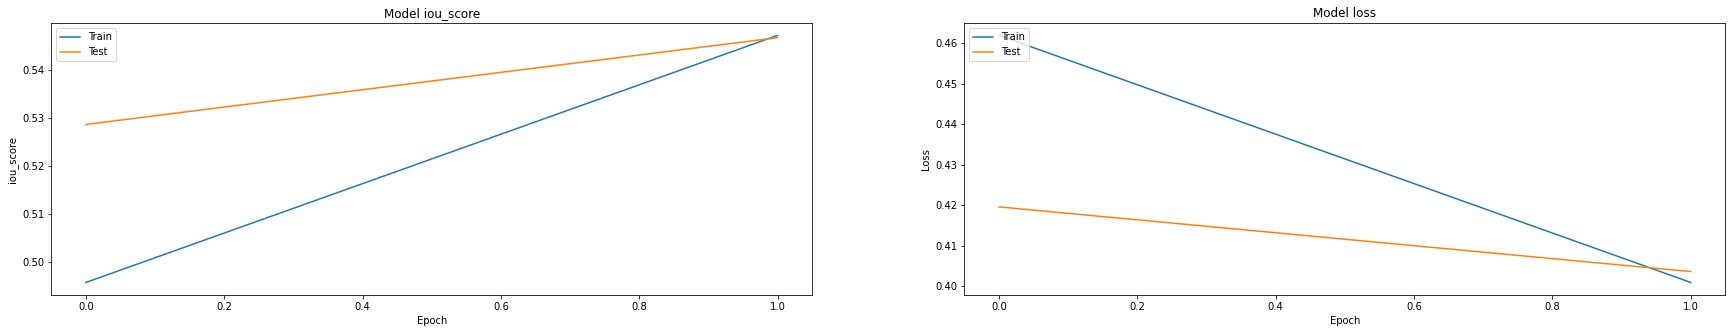

In [75]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

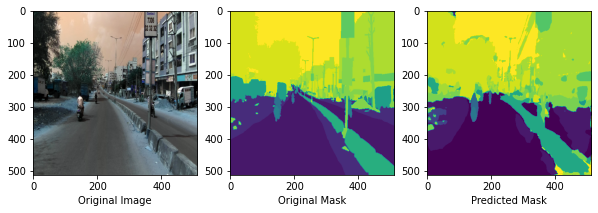

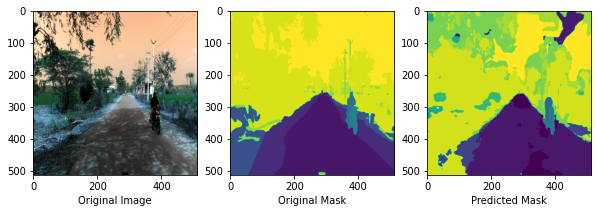

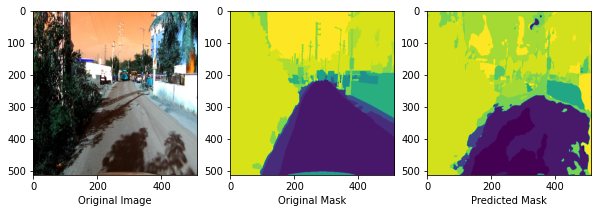

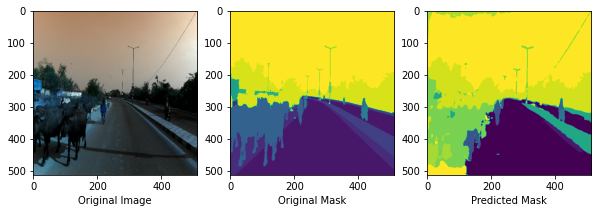

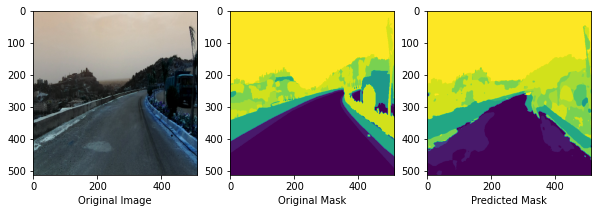

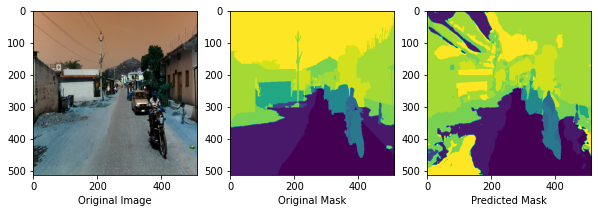

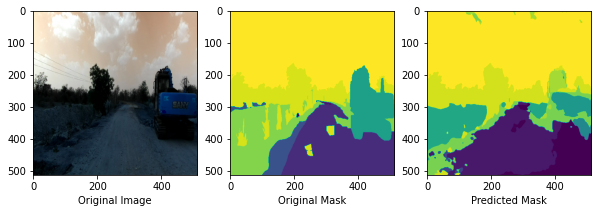

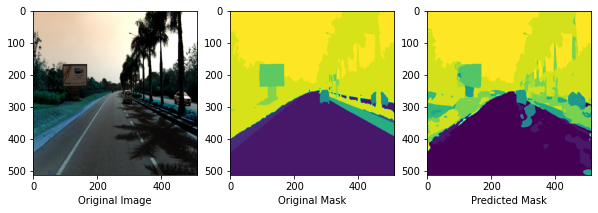

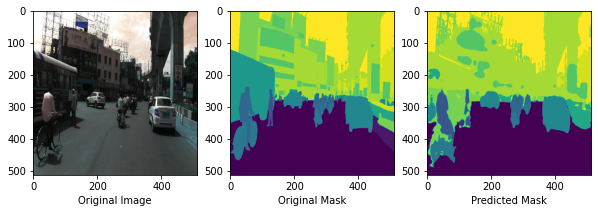

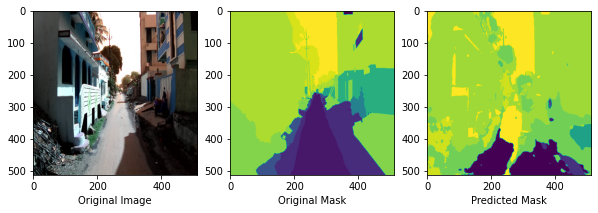

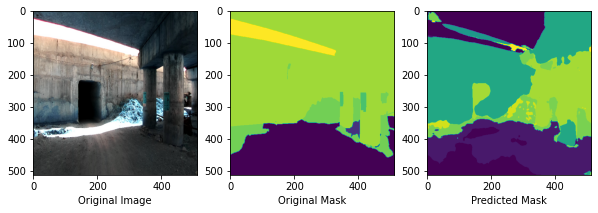

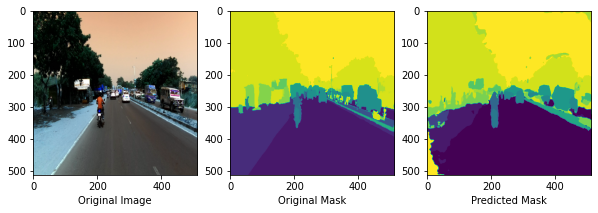

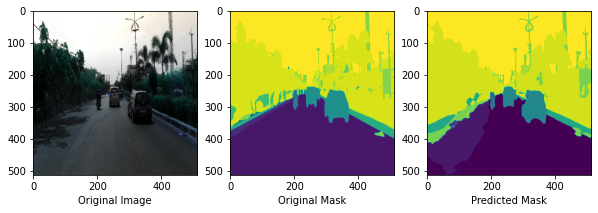

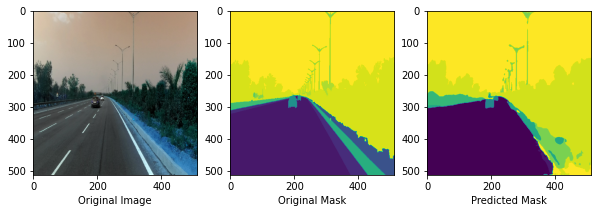

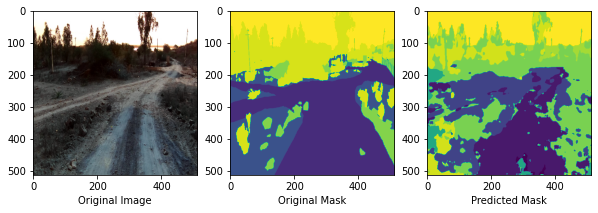

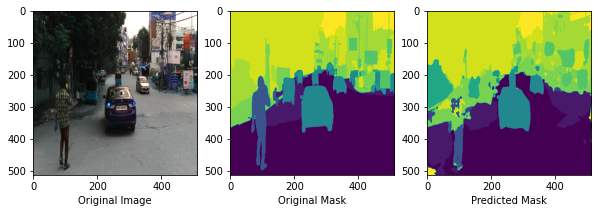

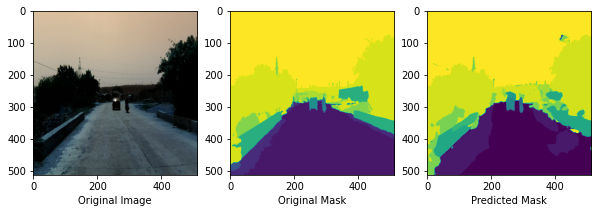

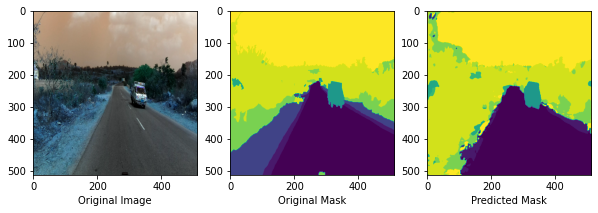

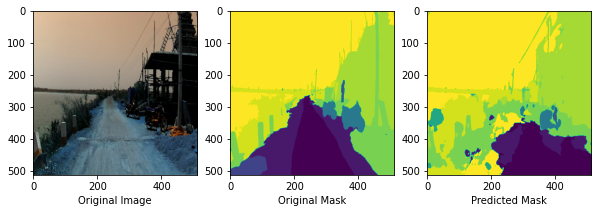

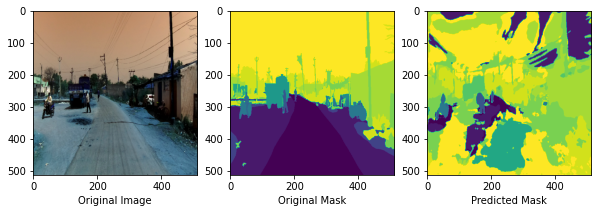

In [77]:
# Visualizing model predictions for 20 images
for i in range(20):
    #original image
    image = cv2.imread(X_test['images'].iloc[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (512,512), interpolation = cv2.INTER_NEAREST) 
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    predicted = tf.argmax(predicted, axis=-1)
    
    #original segmentation map
    image_mask = cv2.imread(X_test['mask'].iloc[i], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512), interpolation = cv2.INTER_NEAREST)

    plt.figure(figsize=(10,10))

    plt.subplot(131)
    plt.imshow(image)
    plt.xlabel('Original Image')

    plt.subplot(132)
    plt.imshow(image_mask,)
    plt.xlabel('Original Mask')

    plt.subplot(133)
    plt.imshow(predicted[0])
    plt.xlabel('Predicted Mask')


plt.show()